In [ ]:
import math
import joblib
import tf_keras as keras

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tf_keras.models import Model
from tf_keras.layers import Input, Lambda, Dense
import tensorflow_probability as tfp

from tqdm import tqdm
from matplotlib import pyplot as plt
from timeit import default_timer

tfd = tfp.distributions
tfb = tfp.bijectors
print("TFP Version", tfp.__version__)
print("TF  Version",tf.__version__)

TFP Version 0.25.0
TF  Version 2.18.0


In [2]:
u_in = np.load("data/poisson1Dinput.npy")
g_uy_out = np.load("data/poisson1Doutput.npy") * 20

In [3]:
g_uy_out.shape

(2000, 100)

In [4]:
def data_formatter(u_data, g_data, sensor_data, nsamp, eval_points=20):

    # Assume f_data and u_data are numpy arrays of shape (500, 100)
    all_u_vals = []
    all_g_vals = []
    all_y_coords = []

    for i in range(nsamp):
        u_i = u_data[i]   # shape: (100,)
        g_i = g_data[i]   # shape: (100,)

        # Randomly sample y-locations (interpolate if needed)
        y_samples = np.random.uniform(0, 1, eval_points)
        g_samples = np.interp(y_samples, sensor_data, g_i)

        for y, g_y in zip(y_samples, g_samples):
            all_u_vals.append(u_i)               # (100,)
            all_y_coords.append([y])             # (1,)
            all_g_vals.append([g_y])             # (1,)

    # Convert to tensors
    u_tensor = np.array(all_u_vals)     # shape: (500×20, 100)
    y_tensor = np.array(all_y_coords)   # shape: (500×20, 1)
    g_tensor = np.array(all_g_vals)     # shape: (500×20, 1)

    return u_tensor, y_tensor, g_tensor

In [5]:
def normalizer(target, source):
    max_s = np.max(source)
    min_s = np.min(source)

    norm_target = (target-min_s)/(max_s-min_s)

    return norm_target

In [6]:
n_total = 2000
n_test = 500
n_grid = 100
rand = 42
u_in_use, g_uy_out_use = u_in[:n_total,...], g_uy_out[:n_total,...]

idxs = np.arange(u_in_use.shape[0])
idx_train, idx_test = train_test_split(idxs, test_size=n_test/n_total, 
                                        random_state=rand)

u_train, g_train = u_in_use[idx_train,:], g_uy_out_use[idx_train,:]
u_test, g_test = u_in_use[idx_test,:], g_uy_out_use[idx_test,:]
sensor_data = np.linspace(0,1,n_grid)

u_in, x_t_in, s_in = data_formatter(u_train, g_train, sensor_data, nsamp=u_train.shape[0], eval_points=50)

In [ ]:
u_in = normalizer(u_in, u_in)
x_t_in = normalizer(x_t_in, x_t_in)
s_in = normalizer(s_in, s_in)
u_test = normalizer(u_test, u_train)
g_test = normalizer(g_test, g_train)

In [8]:
u_in.shape

(75000, 100)

In [9]:
s_in.shape

(75000, 1)

In [10]:
x_t_in.shape

(75000, 1)

In [ ]:
# Use reference's code
bs = 2048  # batch size

def fn(x):
    y = tf.einsum("ij, ij->i", x[0], x[1])
    y = tf.expand_dims(y, axis = 1)
    return y

tfd = tfp.distributions
tfb = tfp.bijectors

def normal_sp(params):
    return tfd.Normal(loc = params[:, 0:1], scale = 0.001+tf.math.softplus(params[:, 1:2]))    

def negloglikelihood(y_true, y_pred):
    return keras.backend.sum(-y_pred.log_prob(y_true))+(sum(model.losses)/bs)

kernel_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (bs * 1.0)
bias_divergence_fn=lambda q, p, _: tfp.distributions.kl_divergence(q, p) / (bs * 1.0)

hln = 25

inputsB = Input(shape = (100,), name = 'inputsB')
hiddenB = tfp.layers.DenseFlipout(hln, bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn, activation = "relu")(inputsB)
hiddenB = tfp.layers.DenseFlipout(hln, bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn, activation = "relu")(hiddenB)
hiddenB = tfp.layers.DenseFlipout(hln, bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn, activation = "relu")(hiddenB)
# hiddenB = tfp.layers.DenseFlipout(hln, bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
#                            bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
#                            kernel_divergence_fn=kernel_divergence_fn,
#                            bias_divergence_fn=bias_divergence_fn, activation = "relu")(hiddenB)
# hiddenB = tfp.layers.DenseFlipout(hln, activation = "relu")(hiddenB)

inputsT = Input(shape = (1,), name = 'inputsT')
hiddenT = tfp.layers.DenseFlipout(hln, bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn, activation = "relu")(inputsT)
hiddenT = tfp.layers.DenseFlipout(hln, bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn, activation = "relu")(hiddenT)
hiddenT = tfp.layers.DenseFlipout(hln, bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
                           bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
                           kernel_divergence_fn=kernel_divergence_fn,
                           bias_divergence_fn=bias_divergence_fn, activation = "relu")(hiddenT)
# hiddenT = tfp.layers.DenseFlipout(hln, bias_posterior_fn=tfp.layers.util.default_mean_field_normal_fn(),
#                            bias_prior_fn=tfp.layers.default_multivariate_normal_fn,
#                            kernel_divergence_fn=kernel_divergence_fn,
#                            bias_divergence_fn=bias_divergence_fn, activation = "relu")(hiddenT)
# hiddenT = tfp.layers.DenseFlipout(hln, activation = "relu")(hiddenT)

combined = Lambda(fn, output_shape = [None, 1])([hiddenB, hiddenT])
output = tfp.layers.DenseFlipout(2)(combined)

dist = tfp.layers.DistributionLambda(normal_sp)(output)
model = Model(inputs = [inputsT, inputsB], outputs = dist)    

model.summary()

/Users/fazaghifari/miniconda3/envs/tfprobenv/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/Users/fazaghifari/miniconda3/envs/tfprobenv/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(
/Users/fazaghifari/miniconda3/envs/tfprobenv/lib/python3.9/site-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inputsB (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 inputsT (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 dense_flipout (DenseFlipou  (None, 25)                   5050      ['inputsB[0][0]']             
 t)                                                                                               
                                                                                                  
 dense_flipout_3 (DenseFlip  (None, 25)                   100       ['inputsT[0][0]']         

In [18]:
def scheduler(epoch):
    if epoch < 200:
        lr = 1e-3
    elif epoch < 1200:
        lr = 5e-4
    elif epoch < 2700:
        lr = 1e-4
    else:
        lr = 5e-5
    
    return lr

In [ ]:
callback = keras.callbacks.LearningRateScheduler(scheduler)
model.compile(
    optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),
    loss=negloglikelihood,
    metrics=["mse"]
)

In [21]:
history = model.fit(x=[x_t_in, u_in], y=s_in, batch_size=bs, epochs=3000, callbacks=[callback], verbose=1)

Epoch 1/3000
37/37 [==============================] - 2s 5ms/step - loss: 2118.6448 - mse: 0.8784 - lr: 0.0010
Epoch 2/3000
37/37 [==============================] - 0s 5ms/step - loss: 1961.1748 - mse: 0.8319 - lr: 0.0010
Epoch 3/3000
37/37 [==============================] - 0s 6ms/step - loss: 1853.2478 - mse: 0.7645 - lr: 0.0010
Epoch 4/3000
37/37 [==============================] - 0s 7ms/step - loss: 1739.6600 - mse: 0.6961 - lr: 0.0010
Epoch 5/3000
37/37 [==============================] - 0s 7ms/step - loss: 1619.0804 - mse: 0.6306 - lr: 0.0010
Epoch 6/3000
37/37 [==============================] - 0s 7ms/step - loss: 1491.5067 - mse: 0.5700 - lr: 0.0010
Epoch 7/3000
37/37 [==============================] - 0s 8ms/step - loss: 1357.1459 - mse: 0.5073 - lr: 0.0010
Epoch 8/3000
37/37 [==============================] - 0s 7ms/step - loss: 1216.3090 - mse: 0.4537 - lr: 0.0010
Epoch 9/3000
37/37 [==============================] - 0s 8ms/step - loss: 1069.9111 - mse: 0.3990 - lr: 0.0010
E

In [ ]:
def mc_preds(y_test, u):
    pred_dist = model([y_test,u])
    y_mean = pred_dist.mean()
    y_sigma = np.sqrt(pred_dist.variance())

    return y_mean, y_sigma

In [ ]:
preds_mean = []
preds_std = []
y_test = sensor_data[:,None]
for i in tqdm(range(100)):
    u = u_test[i][None,:].repeat(100,0)
    pred_mean, pred_std = mc_preds(y_test, u)
    preds_mean.append(pred_mean)
    preds_std.append(pred_std)

100%|██████████| 100/100 [00:05<00:00, 18.96it/s]


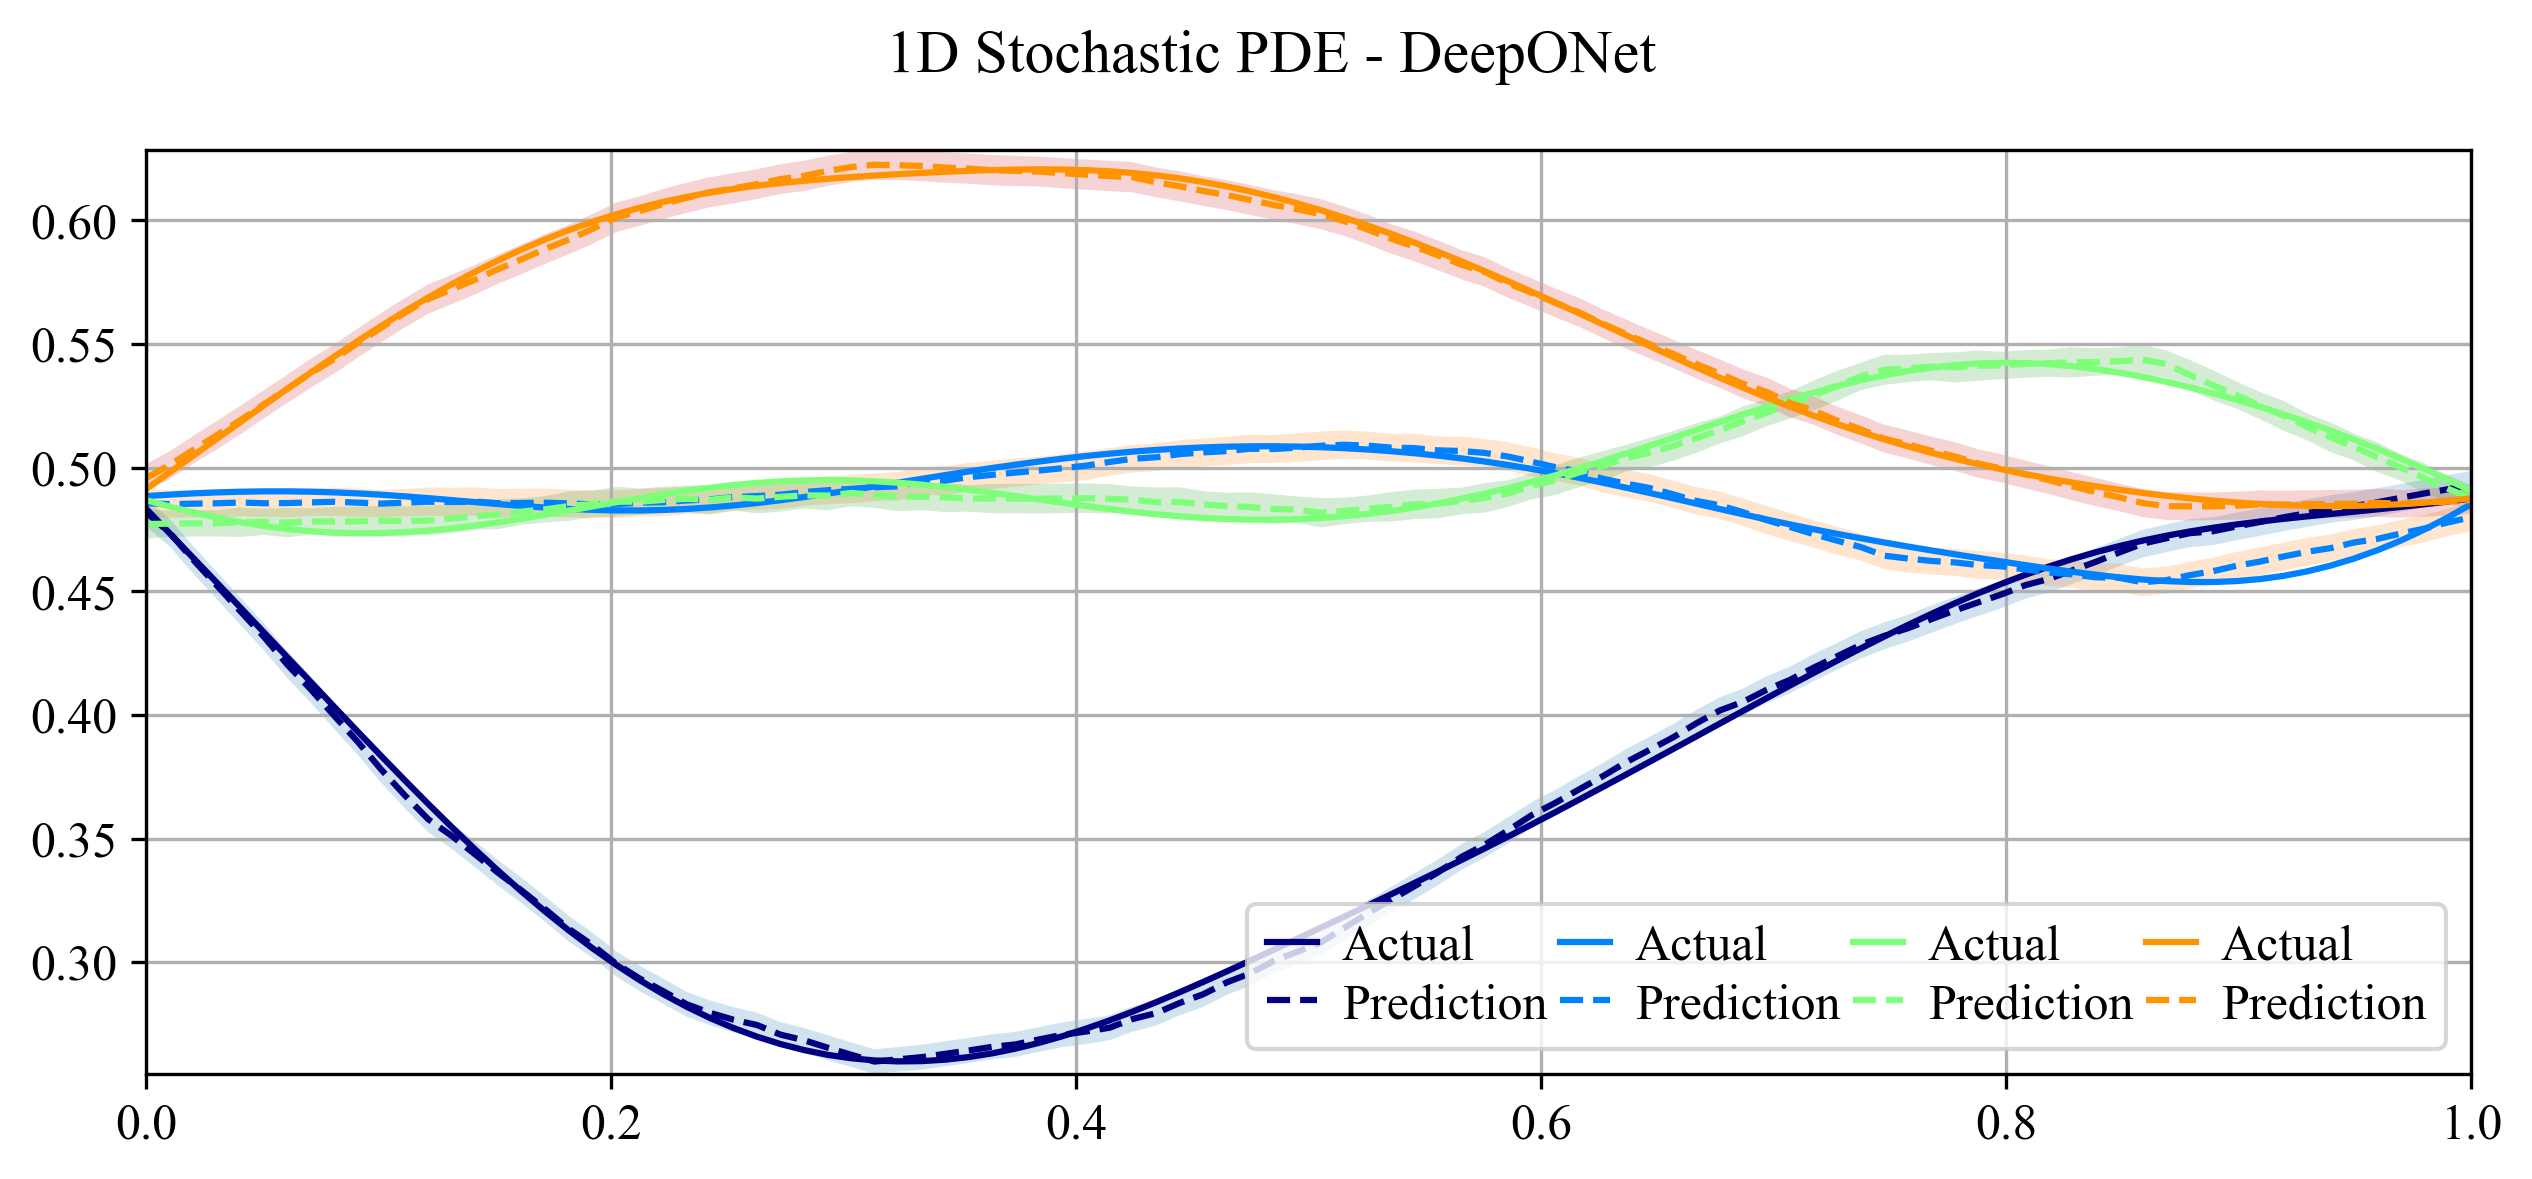

In [53]:
plt.rcParams['font.family'] = 'Times New Roman' 
plt.rcParams['font.size'] = 12
plt.rcParams['mathtext.fontset'] = 'dejavuserif'

colormap = plt.cm.jet  
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

fig2 = plt.figure(figsize = (10, 4), dpi=300)
fig2.suptitle('1D Stochastic PDE - DeepONet')

index = 0
for i in [0,7,42,77]:
    plt.plot(y_test[:,0], g_test[i, :], color=colors[index], label='Actual')
    plt.plot(y_test[:,0], preds_mean[i], '--', color=colors[index], label='Prediction')
    plt.fill_between(
            y_test[:,0],
            (preds_mean[i] - 2*preds_std[i])[:,0],
            (preds_mean[i] + 2*preds_std[i])[:,0],
            alpha=0.2,
        )
    index += 1
plt.legend(ncol=4, loc=4, labelspacing=0.25, columnspacing=0.25, handletextpad=0.5, handlelength=1)
plt.grid(True)
plt.margins(0)